This dataset consists of two distinct sets of single-band GeoTIFFs: one representing the modal vegetation type for each computed over a given era, and one representing the occurence percentage of a given vegetation type for a given era. The former is provided in the alfresco_vegetation_mode_statistic.zip archive, and the latter is provided in the alfresco_vegetation_type_percentage.zip archive. Both subdatasets are derived from the same set of ALFRESCO model runs driven by each of the following five models: GFDL-CM3, NCAR-CCSM4, MRI-CGCM3, IPSL-CM5A-LR, and GISS-E2-R. The calculation for each pixel is done over all years within the era and among all the simulations (200 replicate runs x number of years per simulation). The file naming convention for the modal dataset looks like this: alfresco_relative_vegetation_change_<start year of summary era>-<end year of summary era>_<model>_<scenario>.tif. The convention is identical for the type percentage version, but with an integer code suffix indicating the vegetation type. The mapping for integer value to vegetation type is as follows: 0: not_modeled, 1: black spruce, 2: white spruce, 3: deciduous forest, 4: shrub tundra, 5: graminoid tundra, 6: wetland tundra, 7: barren lichen moss, 8: temperate rainforest The historical runs of the ALFRESCO outputs, driven by CRU-TS, are also included in this revision. For background on ALFRESCO, please refer to the following reference: Daniel H. Mann, T. Scott Rupp, Mark A. Olson, and Paul A. Duffy. 2012. Is Alaska's Boreal Forest Now Crossing a Major Ecological Threshold? Arctic, Antarctic, and Alpine Research 44 (3), 319-331

In [ ]:
# #based on copernicus lc - this is the key
# 0: not modeled --> keep copernicus
# 1: black spruce --> 1
# 2: white spruce --> 1
# 3: deciduous forest --> 2 # copernicus lc did not have deciduous forest, so using mixed forest
# 4: shrub tundra --> 10
# 5: graminoid tundra --> 12
# 6: wetland tundra --> 17 
# 7: barren lichen moss --> 18
# 8: temperate rainforest --> 3 # copernicus lc did not have temperate rainforest, so using mixed forest

In [ ]:
# SM 
# ! The vegetation types are assumed to range from 1 through 30.  The
# !   last 7 types are available to be user-defined vegetation types
# !   and vegetation snow-holding capacities.  The first 23 vegetation
# !   types, and the associated vegetation snow-holding capacities
# !   (depth, in meters), are hard-coded to be:
# !
# ! code description           veg_shc  example                    class
# !
# !  1  coniferous forest       15.00  spruce-fir/taiga/lodgepole  forest
# !  2  deciduous forest        12.00  aspen forest                forest
# !  3  mixed forest            14.00  aspen/spruce-fir/low taiga  forest
# !  4  scattered short-conifer  8.00  pinyon-juniper              forest
# !  5  clearcut conifer         4.00  stumps and regenerating     forest
# ! 
# !  6  mesic upland shrub       0.50  deeper soils, less rocky    shrub
# !  7  xeric upland shrub       0.25  rocky, windblown soils      shrub
# !  8  playa shrubland          1.00  greasewood, saltbush        shrub
# !  9  shrub wetland/riparian   1.75  willow along streams        shrub
# ! 10  erect shrub tundra       0.65  arctic shrubland            shrub
# ! 11  low shrub tundra         0.30  low to medium arctic shrubs shrub
# ! 
# ! 12  grassland rangeland      0.15  graminoids and forbs        grass
# ! 13  subalpine meadow         0.25  meadows below treeline      grass
# ! 14  tundra (non-tussock)     0.15  alpine, high arctic         grass
# ! 15  tundra (tussock)         0.20  graminoid and dwarf shrubs  grass
# ! 16  prostrate shrub tundra   0.10  graminoid dominated         grass
# ! 17  arctic gram. wetland     0.20  grassy wetlands, wet tundra grass
# ! 
# ! 18  bare                     0.01                              bare
# !
# ! 19  water/possibly frozen    0.01                              water
# ! 20  permanent snow/glacier   0.01                              water
# ! 
# ! 21  residential/urban        0.01                              human
# ! 22  tall crops               0.40  e.g., corn stubble          human
# ! 23  short crops              0.25  e.g., wheat stubble         human

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from rasterio.warp import transform
import xarray as xr
import rioxarray as rxr
import glob
import scipy

In [2]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################
# PATHS

# DOMAIN
# choose the modeling domain
domain = 'BEAU'

# path to temporary folder to store tif files from gee
TIFpath = domain + '_GEE_Downloads/'

# path to directory where you want your output .tif and .asc files
dataPath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'

# path to SM
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'

# future landcover out path
histLC_TIFFpath = dataPath+domain+'_veg_hist.tif'
histLC_ASCpath = dataPath+domain+'_veg_hist.asc'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()
    
# domain parameters
nx = domains[domain]['ncols']
ny = domains[domain]['nrows']
clsz = domains[domain]['cellsize']
xll = domains[domain]['xll']
yll = domains[domain]['yll']
st_dt = '2011-10-01'
#########################################################################

In [3]:
# open landcover copernicus
LCfile = dataPath+domain+'_veg.tif'
lcsm = rxr.open_rasterio(LCfile)
# lc to numpy array
LC = np.squeeze(lcsm.values)
# convert to dataset
lc = lcsm.to_dataset('band')
lc = lc.rename({1:'lc'})

In [4]:
# open landcover alfresco
path = '/nfs/attic/dfh/2020_NPRB/data/veg_change/alfresco_relative_vegetation_change_1950-2008_historical.tif'
lcmod = rxr.open_rasterio(path)
lcmod

<xarray.DataArray (band: 1, y: 2100, x: 3650)>
[7665000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.725e+06 -1.724e+06 ... 1.923e+06 1.924e+06
  * y            (y) float64 2.544e+06 2.543e+06 ... 4.459e+05 4.449e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
# reproject to match old landcover data
hlc = lcmod.rio.reproject_match(lcsm)
# numpy array
HLC = np.squeeze(hlc.values)
# add to xarray dataset
lc['hlc_orig']=(['y','x'],np.squeeze(hlc.values))

In [6]:
def veg2sm(indata):
    #change modeled veg to sm categories
    #reclassify white spruce forest & black spruce forest to conifer forest
    update = np.where(indata == 2,1,indata)
    #reclassify deciduous forest to SM number
    update = np.where(indata == 3,2,update)
    # reclassify shrub tundra to erect shrub tundra
    update = np.where(indata == 4,10,update)
    # graminoid tundra as grassland/rangeland
    update = np.where(indata == 5,12,update)
    # reclassify wetland tundra as shrub wetland/riparian
    update = np.where(indata == 6,17,update)
    # reclassify barren lichen to bare
    update = np.where(indata == 7,18,update)
    # reclassify temperate rainforest to mixed forest
    update = np.where(indata == 8,3,update)
    return update
updateHLC = veg2sm(HLC)
lc['hlc']=(['y','x'],updateHLC)
lc

<xarray.Dataset>
Dimensions:      (y: 496, x: 1298)
Coordinates:
  * x            (x) float64 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
  * y            (y) float64 2.456e+06 2.454e+06 ... 1.962e+06 1.96e+06
    spatial_ref  int64 0
Data variables:
    lc           (y, x) uint8 24 24 24 24 24 24 24 24 24 ... 6 6 12 6 6 6 12 6 6
    hlc_orig     (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 3.0 3.0 3.0
    hlc          (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 2.0 2.0 2.0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        24
    STATISTICS_MEAN:           18.094360351562
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         6.7989793979049
    STATISTICS_VALID_PERCENT:  100
    _FillValue:                0.0
    scale_factor:              1.0
    add_offset:                0.0

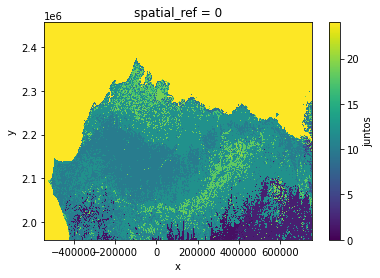

In [7]:
# update vegetation
juntos = np.where(updateHLC>0,updateHLC,LC)
# make sure ocean did not change
juntos = np.where(LC==24,24,juntos)
# make sure water did not change
juntos = np.where(LC==19,19,juntos)
# make sure ice did not change
juntos = np.where(LC==20,20,juntos)
# make sure bare surfaces did not change
juntos = np.where(LC==18,18,juntos)
lc['juntos']=(['y','x'],juntos)
lc.juntos.plot(vmin=0,vmax=24)

In [8]:
# save out historical lc as .tif
lc.juntos.rio.to_raster(histLC_TIFFpath)

In [10]:
# save out future lc as .asc
# open .tif
histlc = rxr.open_rasterio(histLC_TIFFpath)
res = (histlc.x[1]-histlc.x[0]).values.tolist()
# save out future lc as .asc
head = "ncols\t"+str(histlc.shape[2])+"\n" \
    "nrows\t"+str(histlc.shape[1])+"\n" \
    "xllcorner\t"+str(int(min(histlc.x.values)-res/2))+"\n" \
    "yllcorner\t"+str(int(min(histlc.y.values)-res/2))+"\n" \
    "cellsize\t"+str(int(res))+"\n" \
    "NODATA_value\t-9999" 
#save lc
np.savetxt(histLC_ASCpath, np.squeeze(histlc.values), fmt='%d', header = head,comments='')
    

In [11]:
# save out modified topoveg .gdat
# Path to dem and veg files
dem_fname = domain+'_demHF.asc'
veg_fname = domain+'_veg_hist.asc'
demveg_fname = 'dem_veg_'+domain+'_hist.gdat'
demveg_ctl = 'dem_veg_'+domain+'_hist.ctl'
topoveg_path = SMpath+'topo_vege/'

# Path to the flow directions fortran file for editing
mkgdat_fortran = dataPath+'mk_grads_from_ascii_topoveg.f'
print(mkgdat_fortran)

# Function to edit fortran files
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

# edit the .f file for the domain
replace_line(mkgdat_fortran, 7, '      parameter (nx='+nx+',ny='+ny+')\n')
replace_line(mkgdat_fortran, 12, '      open (21,file=\''+dem_fname+'\')\n')
replace_line(mkgdat_fortran, 13, '      open (22,file=\''+veg_fname+'\')\n')
replace_line(mkgdat_fortran, 26, '      open (31,file=\''+demveg_fname+'\',\n')

# execute the function
# Use line magic to change directories to the file locations
# Run the fortran script and save the output
%cd $dataPath
!gfortran mk_grads_from_ascii_topoveg.f
!./a.out

# write out corresponding .ctl file
ctl_list = ['DSET ^'+demveg_fname,
            'TITLE xxxxxxxxxxxxxxxxxxxxxxxxx',
            'UNDEF  -9999.0',
            'XDEF   '+nx+' LINEAR '+xll+' '+clsz,
            'YDEF   '+ny+' LINEAR '+yll+' '+clsz,
            'ZDEF    1 LEVELS 1',
            'TDEF    1 LINEAR 00Z01sep2001 1dy',
            'VARS    2',
            'topo    0  0 topo(m)',
            'veg     0  0 veg type',
            'ENDVARS']
with open(demveg_ctl, 'w') as f:
    f.write('\n'.join(ctl_list))
    
# move files to modeling space 
!mv $demveg_fname $topoveg_path
!mv $demveg_ctl $topoveg_path

/nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/mk_grads_from_ascii_topoveg.f
/nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU


Text(0.5, 1.0, 'combined historical')

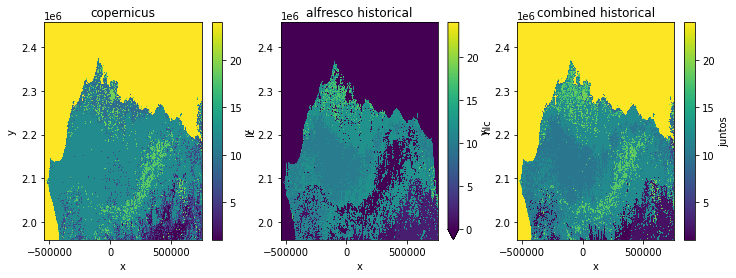

In [12]:
# plots of lc change
fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=[12,4])
lc.lc.plot(ax=ax)
ax.set_title('copernicus')
lc.hlc.plot(ax=ax1,vmin=0,vmax=24)
ax1.set_title('alfresco historical')
lc.juntos.plot(ax=ax2)
ax2.set_title('combined historical')

Text(0.5, 1.0, 'historical combined')

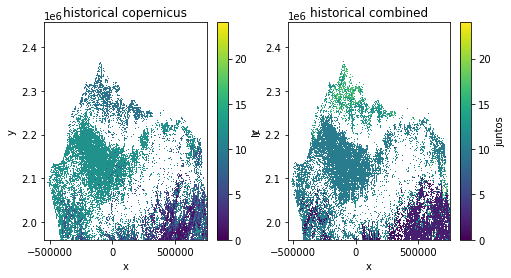

In [13]:
# where lc changed
fig, (ax, ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc!=lc.juntos).plot(ax=ax,vmin =0, vmax = 24)
ax.set_title('historical copernicus')
lc.juntos.where(lc.lc!=lc.juntos).plot(ax=ax1,vmin =0, vmax = 24)
ax1.set_title('historical combined')


Text(0.5, 1.0, 'combined')

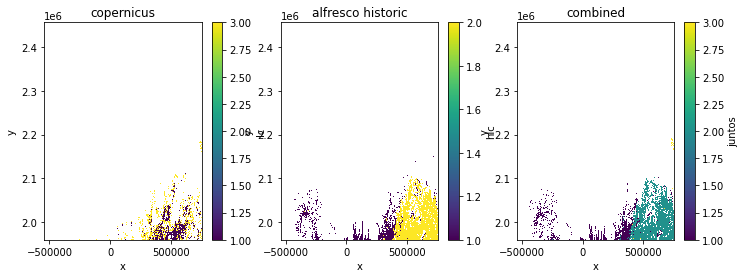

In [14]:
# using reclassified alfresco lc classes to align with sm
fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=[12,4])
lc.lc.where((lc.lc==1)|(lc.lc==2)|(lc.lc==3)).plot(ax=ax)
ax.set_title('copernicus')
lc.hlc.where((lc.hlc==1)|(lc.hlc==2)|(lc.hlc==3)).plot(ax=ax1)
ax1.set_title('alfresco historic')
lc.juntos.where((lc.juntos==1)|(lc.juntos==2)|(lc.juntos==3)).plot(ax=ax2)
ax2.set_title('combined')

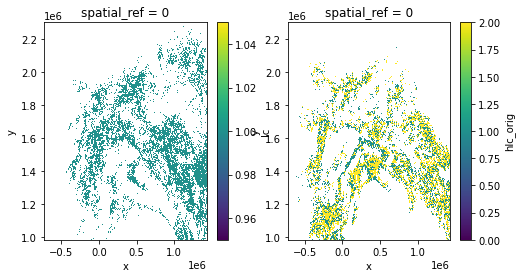

In [58]:
# conifer forest | white spruce forest & black spruce forest
fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
lc.lc.where(lc.lc==1).plot(ax=ax)
lc.hlc_orig.where((lc.hlc_orig==1)|(lc.hlc_orig==2)).plot(ax=ax1,vmin=0)

In [59]:
smcount = lc.lc.where(lc.lc==1).count()
smocount = lc.lc.where((lc.lc==1)&(lc.hlc_orig==1)).count()
smocount1 = lc.lc.where((lc.lc==1)&(lc.hlc_orig==2)).count()
(smocount+smocount1)/smcount

<xarray.DataArray 'lc' ()>
array(0.37205799)
Coordinates:
    spatial_ref  int64 0